# 1. Introduction
In this research I worked with a subset of pitch-level data. The goal was to develop a framework capable of **predicting pitch types**. The pitch types include Fastball , Curveball, Slider and Changeup.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.ensemble import VotingClassifier 
from bayes_opt import BayesianOptimization 
from imblearn.over_sampling import SMOTE

# 2. Feature Preprocessing
First, I checked the data type of each column and whether there were NaN values in it. I then encoded my label, **pitch_type**, with value between 0 and 3. Changeup, Curveball, Fastball, Slider were respectively represented by 0, 1, 2 and 3. Finally, I converted the data types of **pitcher_id**, **pitcher_side**, **pitch_type** to category types. The data types of **pitch_initial_speed_a**, **break_x_a**, **break_z_a**, **pitch_initial_speed_b**, **spinrate_b**, **break_x_b** and **break_z_b** remain as integer types.

In [2]:
# Load the data
df = pd.read_csv(r'C:\Users\allen\Desktop\Baseball Analytics Coding Task\SDP\Data Project Data.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 500
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pitcher_id             5000 non-null   int64  
 1   pitcher_side           5000 non-null   object 
 2   pitch_type             4000 non-null   object 
 3   pitch_initial_speed_a  2997 non-null   float64
 4   break_x_a              2997 non-null   float64
 5   break_z_a              2997 non-null   float64
 6   pitch_initial_speed_b  2995 non-null   float64
 7   spinrate_b             2876 non-null   float64
 8   break_x_b              2976 non-null   float64
 9   break_z_b              2976 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 429.7+ KB


In [3]:
# Split the data into training data(with known pitch_type) and testing data(without known pitch_type)
df_training = df[df['pitch_type'].notnull()].reset_index(drop=True)
df_testing = df[df['pitch_type'].isnull()].reset_index(drop=True)

In [4]:
# Encode the label and convert the data types
# Feature encoding and data type conversion
for feature in ['pitch_type', 'pitcher_side']:
    le = preprocessing.LabelEncoder()
    le.fit(df_training[feature])
    encoded_label = le.transform(df_training[feature])
    df_training[feature] = pd.DataFrame(encoded_label)
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

categorical_variables = ['pitcher_id', 'pitcher_side', 'pitch_type']
for variable in categorical_variables:
    df_training[variable] = df_training[variable].astype("category")
    
df_training.info()

{'Changeup': 0, 'Curveball': 1, 'Fastball': 2, 'Slider': 3}
{'L': 0, 'R': 1}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   pitcher_id             4000 non-null   category
 1   pitcher_side           4000 non-null   category
 2   pitch_type             4000 non-null   category
 3   pitch_initial_speed_a  2498 non-null   float64 
 4   break_x_a              2498 non-null   float64 
 5   break_z_a              2498 non-null   float64 
 6   pitch_initial_speed_b  2495 non-null   float64 
 7   spinrate_b             2395 non-null   float64 
 8   break_x_b              2476 non-null   float64 
 9   break_z_b              2476 non-null   float64 
dtypes: category(3), float64(7)
memory usage: 231.3 KB


## 2.1 Opposite Values for Right-handed and Left-handed Pitchers
In order to classify the pitches based on their characteristics, it's important to notice that measurements in the horizontal direction had opposite values for right-handed and left-handed pitchers for the same type of pitch.

Therefore, in this section, in order to show the importance, I first displayed **break_x_a** and **break_z_a** in two plots regarding right-handed and left-handed pitchers repectively. After that, I multiplied the values of **break_x_a** and **break_x_b** regarding left-handed pitchers by -1. Finally, after multiplying, I again displayed **break_x_a** and **break_z_a** in a plot.

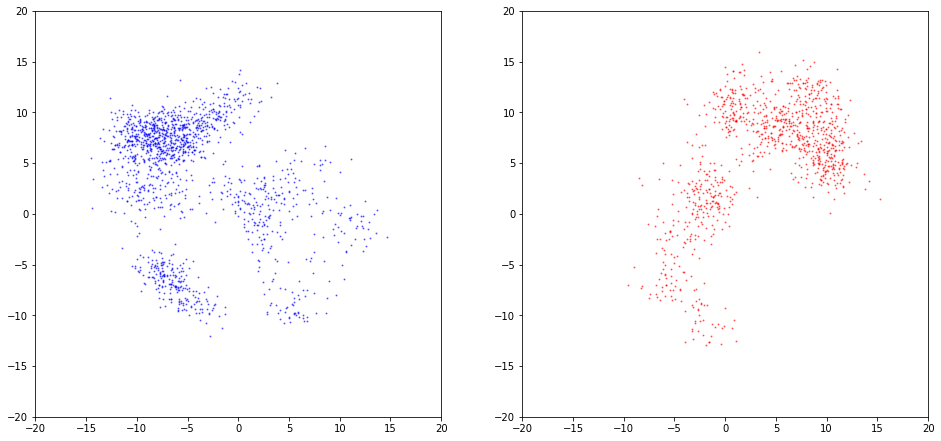

In [5]:
# Plot break_x_a and break_z_a
x1 = df_training.loc[df_training['pitcher_side'] == 1]['break_x_a']
y1 = df_training.loc[df_training['pitcher_side'] == 1]['break_z_a']
x2 = df_training.loc[df_training['pitcher_side'] == 0]['break_x_a']
y2 = df_training.loc[df_training['pitcher_side'] == 0]['break_z_a']

fig, ax = plt.subplots(1,2,figsize=(16,8))
for ax1 in ax:
    ax1.axis('scaled')
    ax1.set_xlim([-20, 20])
    ax1.set_ylim([-20, 20])
ax[0].scatter(x1, y1, color="blue", alpha=.5, s=1)
ax[1].scatter(x2, y2, color="red", alpha=.5, s=1)
plt.show()

In [6]:
# Multiplying
df_training.loc[(df_training['pitcher_side'] == 0), 'break_x_a'] *= (-1)
df_training.loc[(df_training['pitcher_side'] == 0), 'break_x_b'] *= (-1)

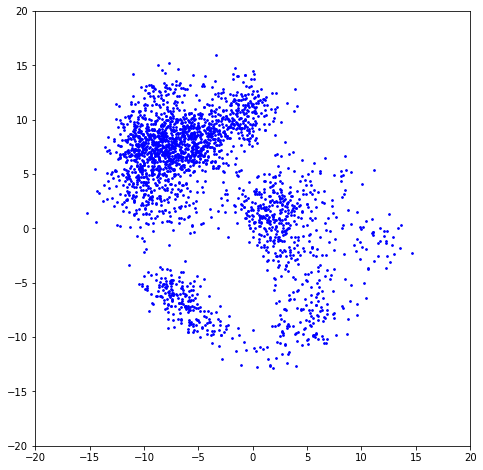

In [7]:
x1 = df_training['break_x_a']
y1 = df_training['break_z_a']

fig, ax = plt.subplots(figsize=(8,8))
ax.axis('scaled')
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.scatter(x1, y1, color="blue", alpha=1, s=3)
plt.show()

# 3. Methodology
## 3.1 Model Building and Hyperparameter Tuning
After preprocessing, I defined my machine learning problem. Again, my goal was to predict pitch types. Therefore, on the basis of the given data, I was able to regard pitch_type as my classification label and further considered our problem as a classification problem. Besides, I regarded **pitcher_id**, **pitcher_side** , **pitch_initial_speed_a**, **break_x_a**, **break_z_a**, **pitch_initial_speed_b**, **spinrate_b**, **break_x_b**, **break_z_b** as my predictors. In this section, I defined two important functions to assist me in building classification models and tuning their hyperparameters.

In detail, I applied *LightGBM*, a gradient boosting framework that uses tree based learning algorithms, to my classification problem. It is designed to be distributed and efficient with the following advantages: faster training speed and higher efficiency, lower memory usage, better accuracy, capable of handling large-scale data, and support of parallel, distributed, and GPU learning. Next, regarding hyperparameter tuning, I used *Bayesian Optimization* instead of Grid Search and Random Search since Bayesian Optimization is far more efficient in saving time and has better overall performance.

In [8]:
# Define a function to tune parameters using baysian optimization
def bayes_tuning(X, y, params, init_round=15, opt_round=25, random_state=42, n_estimators=10000, oversampling=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if oversampling == True:
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
    else:
        pass
           
    def lgb_function(learning_rate, num_leaves, max_depth, min_child_samples):

        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['num_leaves'] = int(round(num_leaves))
        params['max_depth'] = int(round(max_depth))
        params['min_child_samples'] = int(round(min_child_samples))
        
        lgbc = lgb.LGBMClassifier(**params)
        lgbc.fit(X_train, y_train)
        y_pred = lgbc.predict(X_test)
        accuracy = precision_score(y_pred, y_test, average='micro')

        return accuracy
      
    lgbBO = BayesianOptimization(lgb_function, {'learning_rate':(0.01,1.0), 'num_leaves':(30,200),                                            
                                                'max_depth':(1,30), 'min_child_samples':(20,80)}, random_state=42)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    model_auc = []
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
        
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'], lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [9]:
# Define a function to fit the data using lightgbm with the optimal parameters
def lgb_classification(X, y, params, optimal_params, oversampling=False):
    
    for param in optimal_params[1].keys():
        if param == 'learning_rate':
            optimal_params[1][param] = round(optimal_params[1][param], 2)
        else:
            optimal_params[1][param] = int(round(optimal_params[1][param]))
    params.update(optimal_params[1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if oversampling == True:
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
    else:
        pass    
    lgbc = lgb.LGBMClassifier(**params)
    lgbc.fit(X_train, y_train)
    y_pred = lgbc.predict(X_test)
    accuracy = precision_score(y_pred, y_test, average='micro')
    cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    return lgbc, accuracy, cf_matrix 

## 3.2 Model Evaluation
After defining the functions for building LightGBM models and tuning hyperparameters, I then looked at the distribution of my label, **pitch_type**. Unsurprisingly, the number of 4-Seam fastballs was way larger than the rest of the pitch types. As a result, in addition to directly fitting the original training dataset, I also tried to set class weights for my label and balance the training dataset using over-sampling techniques, SMOTE. In the end of this section, I evaluated the three approaches above through comparing overall test accuracy and confusion matrix.

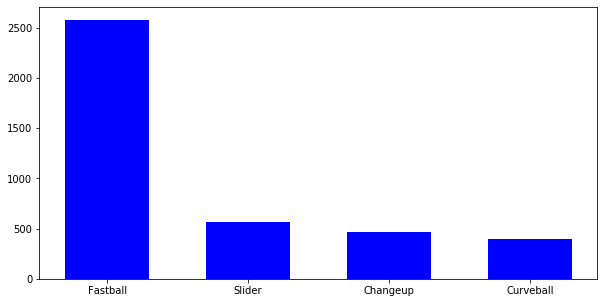

In [10]:
# distribution of the label
types = ('Fastball', 'Slider', 'Changeup', 'Curveball')
y_pos = np.arange(len(types))
n = df_training['pitch_type'].value_counts().to_list()
plt.figure(figsize=(10, 5))
plt.bar(y_pos, n, align='center', width=0.6, color='b')
plt.xticks(y_pos, types)
plt.show()

In [11]:
# Model 1 (original dataset)
X = df_training.drop(['pitch_type'], axis=1).to_numpy()
y = df_training[['pitch_type']].to_numpy().ravel()
params = {'boosting_type':'gbdt', 'objective':'binary'}
optimal_params_1 = bayes_tuning(X, y, params)
lgbc_results_1 = lgb_classification(X, y, params, optimal_params_1)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.995    |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.9938   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.9938   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.9925   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.995    |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.9925   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.9912   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.9912   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.9938   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.9925   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.9925   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.9938   |  0.2662   | 

In [12]:
# Model 2 (over-sampling technique)
# Set input and output elements
X = df_training.drop(['pitch_type'], axis=1).to_numpy()
X1 = df_training.drop(['pitch_type'], axis=1)
# Define imputer to deal with NaN value for SMOTE
imputer = KNNImputer()
# Fit on the dataset
imputer.fit(X)
# Transform the dataset
Xtrans = imputer.transform(X)
# Put the transformed dataset back into pitch_data_include
X1[X1.columns]=Xtrans
# Set input and output elements again
X = X1.to_numpy()
y = df_training[['pitch_type']].to_numpy().ravel()

params = {'boosting_type':'gbdt', 'objective':'multiclass', 'num_class':5, 'class_weight':None}
optimal_params_2 = bayes_tuning(X, y, params, oversampling=True)
lgbc_results_2 = lgb_classification(X, y, params, optimal_params_2, oversampling=True)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.9775   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.98     |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.9775   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.9775   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.9775   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.98     |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.9788   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.9738   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.9788   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.9788   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.9775   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.98     |  0.2662   | 

In [13]:
# Model 3 (class weight adjustment)
X = df_training.drop(['pitch_type'], axis=1).to_numpy()
y = df_training[['pitch_type']].to_numpy().ravel()
params = {'boosting_type':'gbdt', 'objective':'multiclass', 'num_class':5, 'class_weight':'balanced'}
optimal_params_3 = bayes_tuning(X, y, params)
lgbc_results_3 = lgb_classification(X, y, params, optimal_params_3)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.995    |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.99     |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.9925   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.9938   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.9938   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.9938   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.9938   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.9938   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.9925   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.9938   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.9912   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.9912   |  0.2662   | 

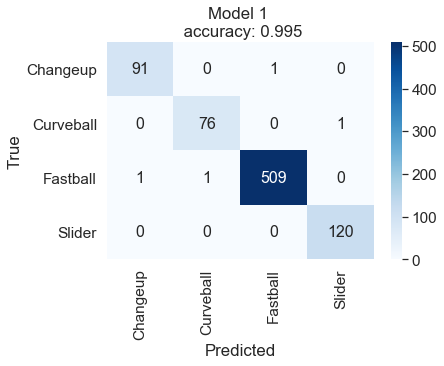

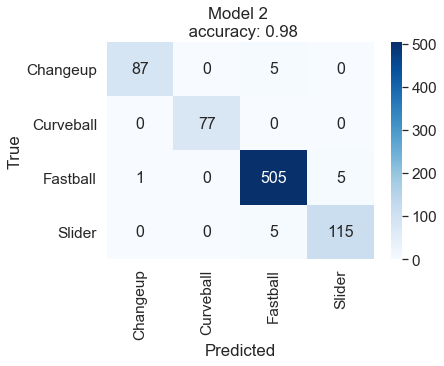

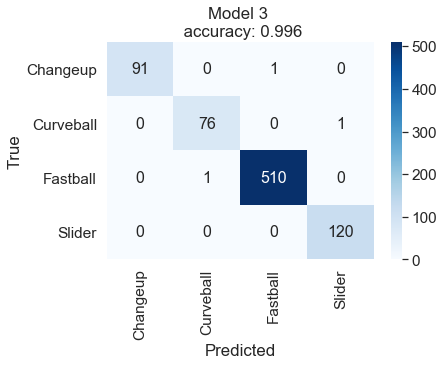

In [14]:
# Compare test accuracy and confusion matrix
for result in [lgbc_results_1, lgbc_results_2, lgbc_results_3]:
    model_index = [lgbc_results_1, lgbc_results_2, lgbc_results_3].index(result)+1
    label = ['Fastball', 'Slider', 'Changeup', 'Curveball']
    data = result[2]
    df_cm = pd.DataFrame(data, columns=np.unique(label), index=np.unique(label))
    df_cm.index.name = 'True'
    df_cm.columns.name = 'Predicted'        
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
    plt.title('Model {} \n accuracy: {}'.format(model_index ,round(result[1],3)))
    plt.show()

**Model 1** represents that I train a LightGBM model and tune its hyperparameters using the original training dataset.<br>
**Model 2** represents that I train a LightGBM model and tune its hyperparameters using the resampled training dataset.<br> 
**Model 3** represents that I train a LightGBM model with class weights and tune its hyperparameters using the original training dataset.<br> 
It's worthy to note that the test dataset is the same for each model.

As shown in above figures, **Model 3** outperforms **Model 1** and **Model 2** on overall test accuracy. But all of them were quite effective with an accuracy over at least 98%. The reason for **Model 2** being slightly less effective than **Model 1** and **Model 3** probably was it's being processed with KNN Imputer to impute missing values. To perform SMOTE, there might be a better way to deal with the missing value to make the **Model 2** more effective.

Moreover, I then tried to figure out which features have significant impact on predicting **pitch_type** by calculating feature importance regarding each proposed model. As shown in below figures, all of them except **pitcher_side** had significant impacts on predicting pitch_type. This is pretty reasonable since **pitch speed**, **movement** and **spin rate** are features that we distinguish one pitch kind from another usually. 

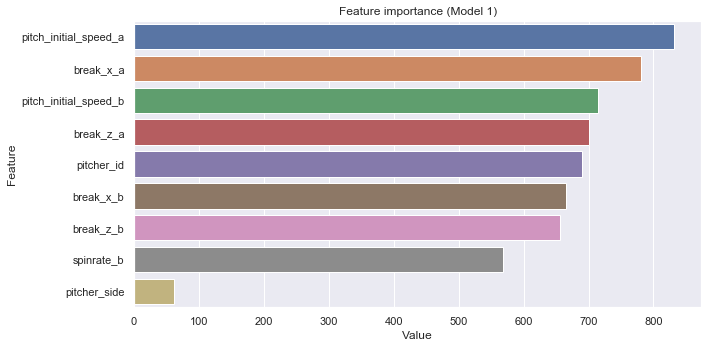

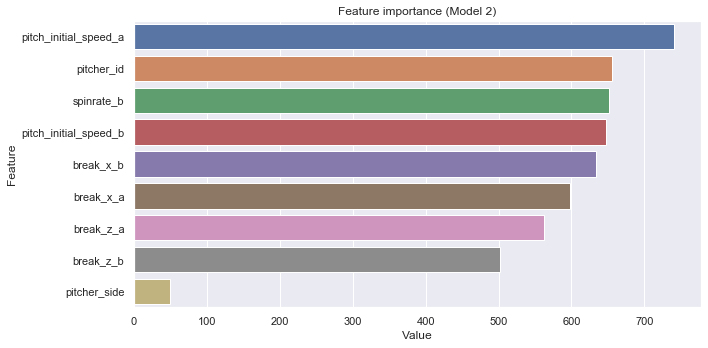

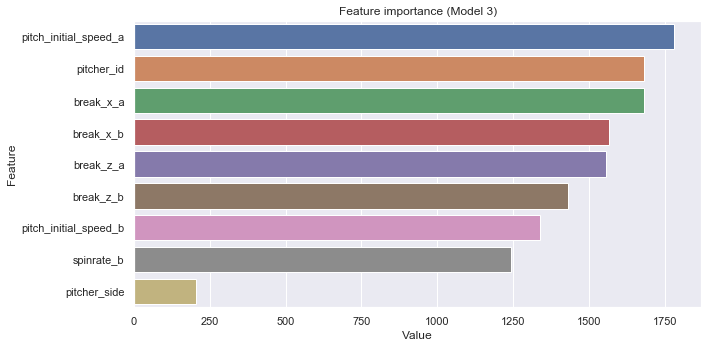

In [15]:
for result in [lgbc_results_1, lgbc_results_2, lgbc_results_3]:
    model_index = [lgbc_results_1, lgbc_results_2, lgbc_results_3].index(result)+1
    feature_imp = pd.DataFrame({'Value':result[0].feature_importances_,
                                'Feature':df_training.drop('pitch_type', axis=1).columns})
    plt.figure(figsize=(10, 5))
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:13])
    plt.title('Feature importance (Model {})'.format(model_index))
    plt.tight_layout()
    plt.show()

## 3.3 Voting Classifier
To see a better picture and potentially combine the advantages of all the three models, I used **voting**, an ensemble machine learning algorithm, to combine the predictions from my three proposed models. It is a technique that may be used to improve model performance, ideally achieving better performance than any single model used in the ensemble.

In the case of classification, the predictions for each label are summed and the label with the majority vote was predicted. There are two approaches to the majority vote prediction for classification: **hard voting** and **soft voting**. **Hard voting** uses predicted class labels for majority rule voting while **soft voting** predicts the class label based on the argmax of the sums of the predicted probabilities. I used soft voting this time.

As shown in below figure, comparing with the result of **Model 3**, **Model after voting** maintained the same overall test accuracy and further proved its effectiveness.

In [16]:
# Build a voting classifer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eclf = VotingClassifier(estimators=[('model_1', lgbc_results_1[0]),
                                    ('model_2', lgbc_results_2[0]),
                                    ('model_3', lgbc_results_3[0])], voting='soft')
eclf = eclf.fit(X_train, y_train)

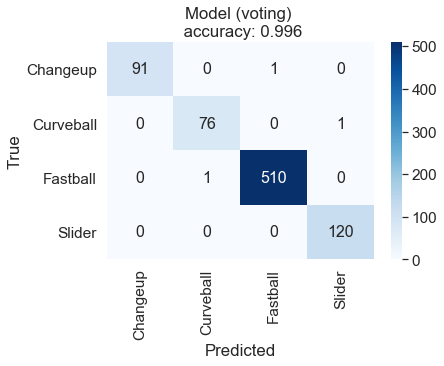

In [17]:
# Test accuracy and confusion matrix
y_pred = eclf.predict(X_test)
accuracy = precision_score(y_pred, y_test, average="micro")

label = ['Fastball', 'Slider', 'Changeup', 'Curveball']
data = confusion_matrix(y_true=y_test, y_pred=y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(label), index=np.unique(label))
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'        
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
plt.title('Model (voting) \n accuracy: {}'.format(round(accuracy,3)))
plt.show()

# 4. Prediction
After finishing preparing our model, I then used my model to provide predictions.

In [18]:
# Encode the label and convert the data types
# feature encoding and data type conversion
for feature in ['pitcher_side']:
    le = preprocessing.LabelEncoder()
    le.fit(df_testing[feature])
    encoded_label = le.transform(df_testing[feature])
    df_testing[feature] = pd.DataFrame(encoded_label)
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
    
categorical_variables = ['pitcher_id', 'pitcher_side']
for variable in categorical_variables:
    df_testing[variable] = df_testing[variable].astype("category")

# Adjusting opposite Values for Right-handed and Left-handed Pitchers
df_testing.loc[(df_testing['pitcher_side'] == 0), 'break_x_a'] *= (-1)
df_testing.loc[(df_testing['pitcher_side'] == 0), 'break_x_b'] *= (-1)

{'L': 0, 'R': 1}


In [19]:
# Make the prediction and update the csv file
X = df_testing.drop(['pitch_type'], axis=1).to_numpy()
y_pred = eclf.predict(X)
df_testing['pitch_type'] = y_pred
df_testing['pitcher_side'] = df_testing['pitcher_side'].map({0:'L', 1: 'R'})
df_testing['pitch_type'] = df_testing['pitch_type'].map({0:'Changeup', 1: 'Curveball', 2: 'Fastball', 3: 'Slider'})
df_testing.head()

,pitcher_id,pitcher_side,pitch_type,pitch_initial_speed_a,break_x_a,break_z_a,pitch_initial_speed_b,spinrate_b,break_x_b,break_z_b
0,15865,R,Slider,84.9,0.60,4.18,NaN,NaN,NaN,NaN
1,15865,R,Slider,85.0,1.16,1.22,NaN,NaN,NaN,NaN
2,15865,R,Curveball,75.0,4.62,-4.65,NaN,NaN,NaN,NaN
3,15865,R,Slider,81.0,2.75,-1.93,NaN,NaN,NaN,NaN
4,15865,R,Slider,82.9,0.25,-1.47,NaN,NaN,NaN,NaN


# 5. Conclusion:
In this task, in order to predicting pitch types, I basically developed a framework including preprocessing features, building predictive models, tuning hyperparameters, evaluating the models, and calculating feature importance. Although the result might not be perfect, I believed that I have provided a reliable framework to deal with this kind of issue. Also it further proved that **pitch speed**, **movement** and **spin rate** are features that we can use to distinguish one pitch kind from another.